# Features Preprocessing

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [7]:
X_train_input = np.load('Data/X_train.npy')
Y_train_input = np.load('Data/Y_train.npy')

print("X shape =", X_train_input.shape)
print("Y shape =", Y_train_input.shape)

X shape = (700, 6)
Y shape = (700,)


In [12]:
X_scaled = StandardScaler().fit_transform(X_train_input)

print("means:", np.round(X_scaled.mean(axis=0), 4))
print("stds: ", np.round(X_scaled.std(axis=0), 4))

means: [-0. -0.  0.  0.  0. -0.]
stds:  [1. 1. 1. 1. 1. 1.]


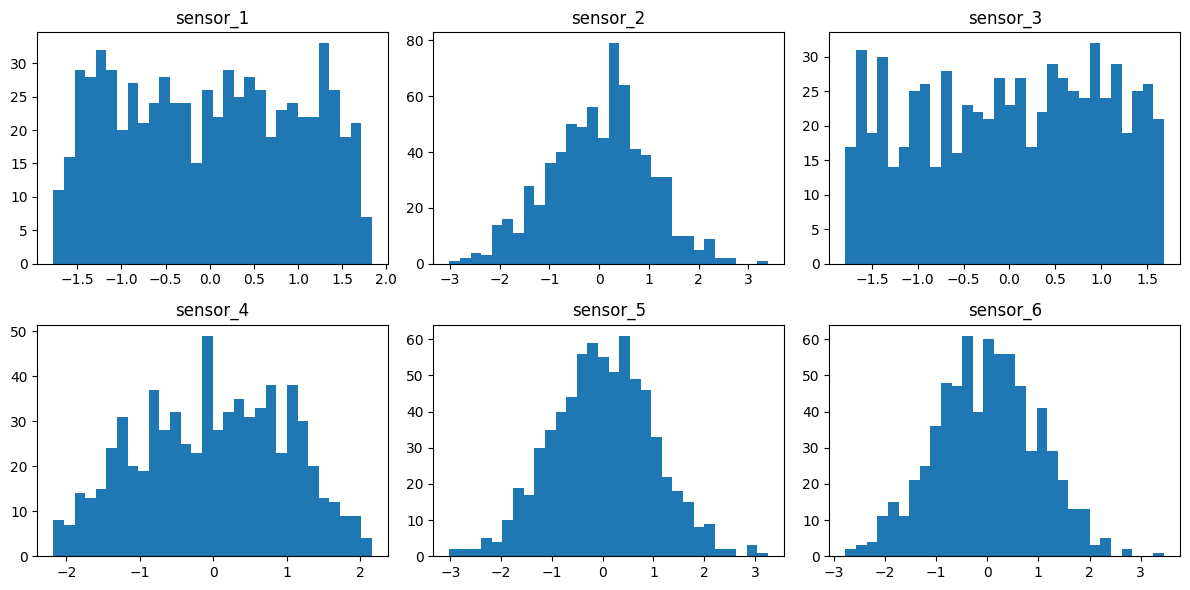

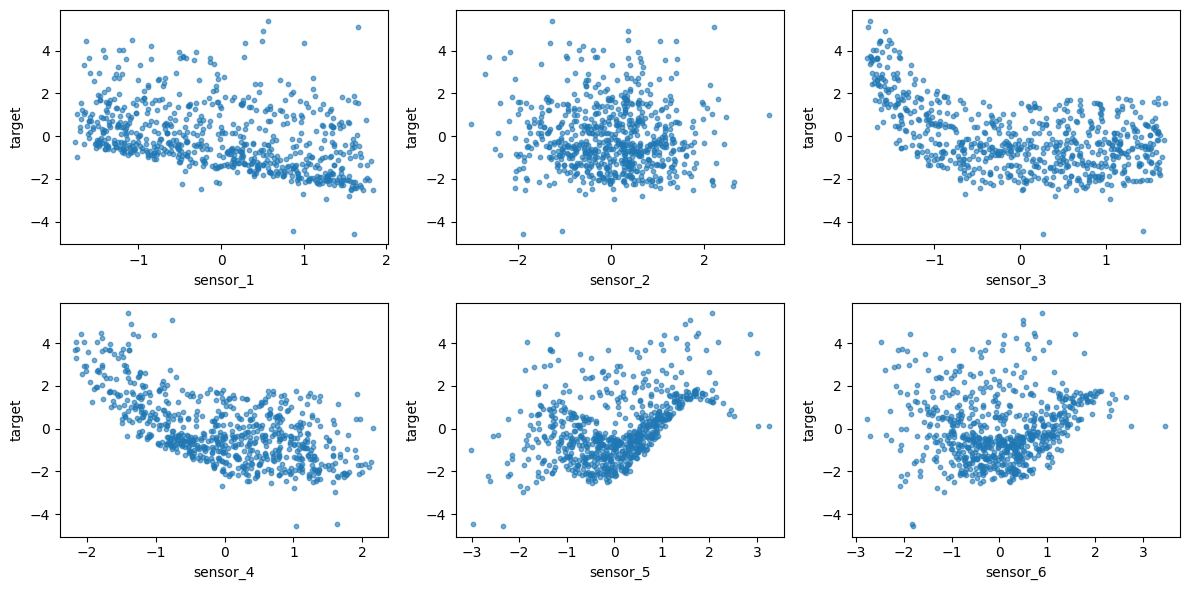

In [ ]:
# Histograms
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, ax in enumerate(axes.ravel()):
    ax.hist(X_scaled[:, i], bins=30)
    ax.set_title(f"sensor_{i+1}")
plt.tight_layout()
plt.show()

# Sccatter each feature vs Target
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, ax in enumerate(axes.ravel()):
    ax.scatter(X_scaled[:, i], Y_train_input, s=10, alpha=0.6)
    ax.set_xlabel(f'sensor_{i+1}')
    ax.set_ylabel('target')
plt.tight_layout()
plt.show()


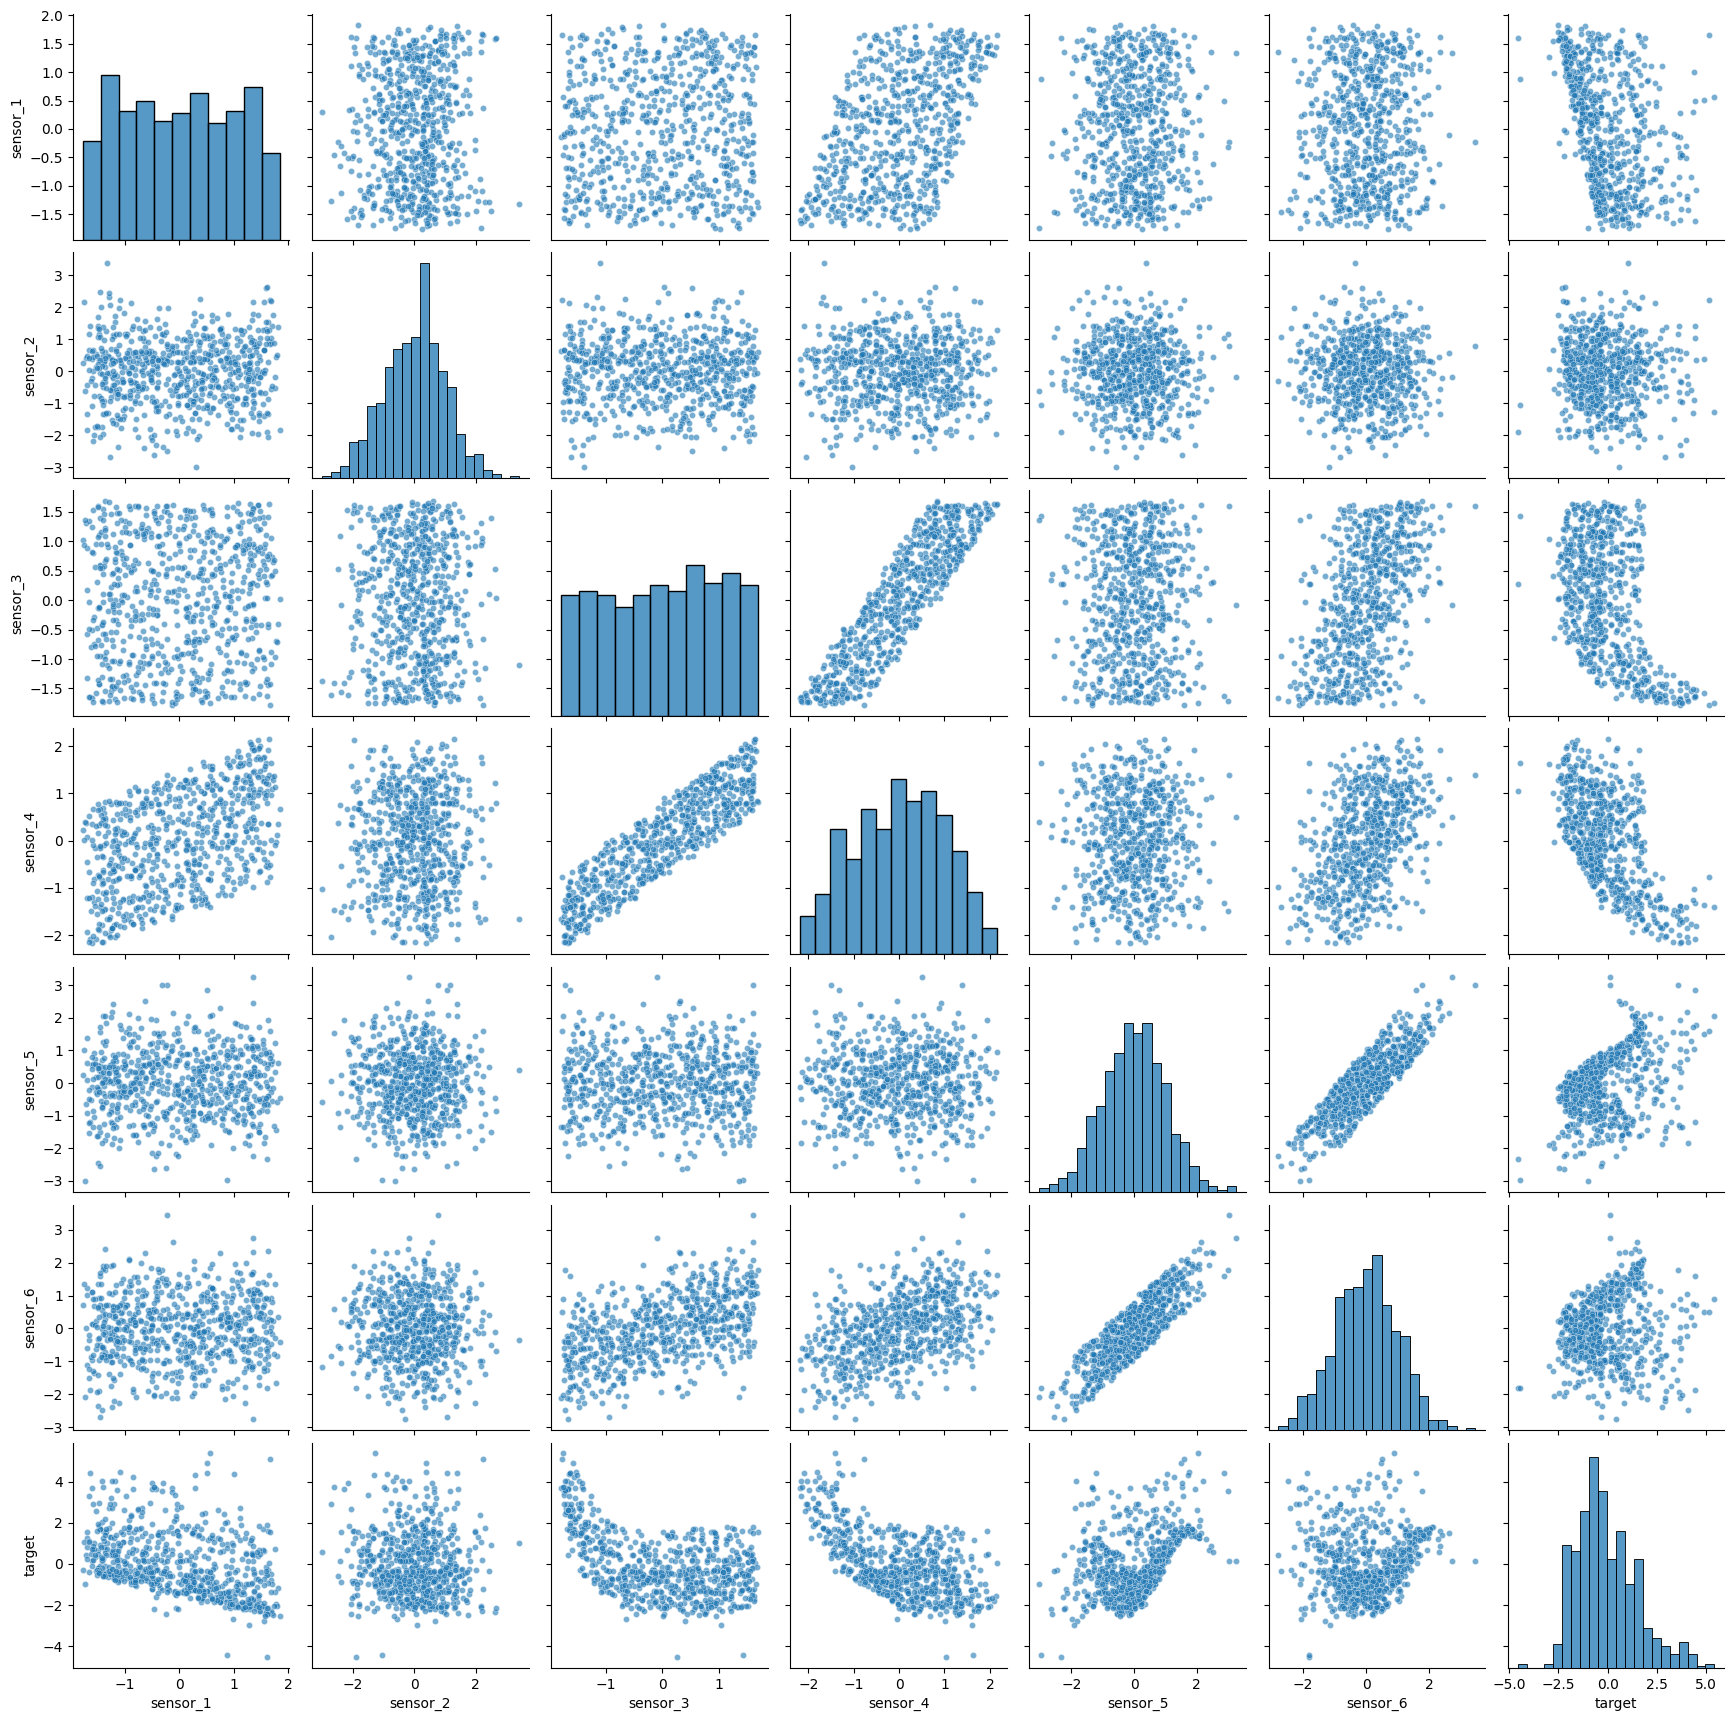

In [16]:
# Combine features and target into a DataFrame
df = pd.DataFrame(X_scaled, columns=[f'sensor_{i+1}' for i in range(X_scaled.shape[1])])
df['target'] = Y_train_input

# Pairplot
sns.pairplot(df, diag_kind='hist', kind='scatter', plot_kws={'alpha':0.6, 's':20})
plt.show()

Feature vs target correlations (sorted by abs):
sensor_4    0.615151
sensor_3    0.498314
sensor_5    0.405033
sensor_1    0.402298
sensor_6    0.094479
sensor_2    0.050452
Name: target, dtype: float64


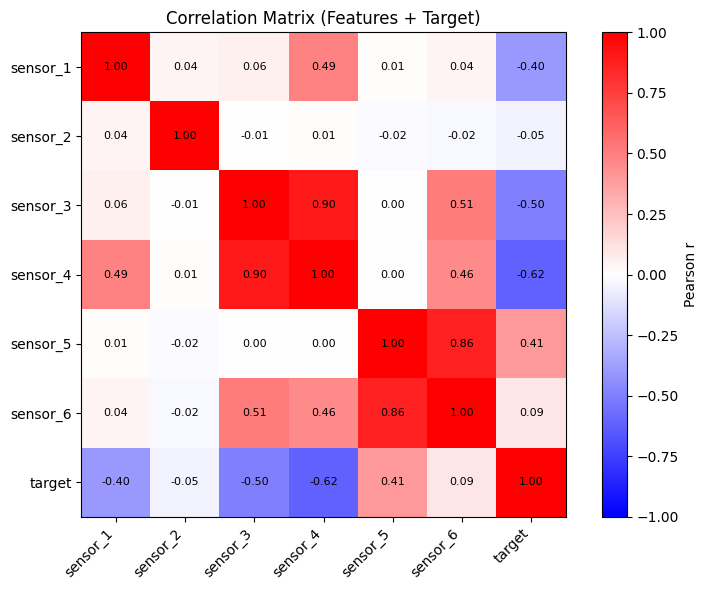

In [ ]:
# Create DataFrame with sensor features and target
colnames = [f"sensor_{i+1}" for i in range(X_scaled.shape[1])]
df = pd.DataFrame(X_scaled, columns=colnames)
df['target'] = Y_train_input

# Compute Pearson correlation matrix
corr = df.corr()

# Extract correlations of each feature with the target
feat_target_corr = corr['target'].drop('target')

# Print sorted feature–target correlations (absolute value)
print("Feature vs target correlations (sorted by abs):")
print(feat_target_corr.abs().sort_values(ascending=False))


# Heatmap of correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr', interpolation='nearest')
plt.colorbar(label='Pearson r')

# Axis ticks
ticks = np.arange(len(corr))
plt.xticks(ticks, corr.columns, rotation=45, ha='right')
plt.yticks(ticks, corr.columns)

# Add numeric correlation values to each cell
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha='center', va='center', fontsize=8)

plt.title("Correlation Matrix (Features + Target)")
plt.tight_layout()
plt.show()


# Outlier Removal

In [31]:
# load Datasets
X_train_input = np.load('Data/X_train.npy')
Y_train_input = np.load('Data/Y_train.npy')

# Split the dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_train_input, test_size=200, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Isolation Forest method 
iso = IsolationForest(contamination=0.01, random_state=42)
is_outlier_iso = iso.fit_predict(X_train_scaled) == -1
print("IsolationForest outliers:", is_outlier_iso.sum())

# Z-score method ( Compute absolute z-scores and applt the threshold)
zs = np.abs(zscore(X_train_scaled))     
z_thresh = 3.0                        
outlier_mask_z = (zs > z_thresh).any(axis=1)
print("Z-score outliers:", outlier_mask_z.sum())

# Combination of methods 
# Union → a sample is an outlier if detected by any method
outlier_union = outlier_mask_z | is_outlier_iso
print("Outliers (union):", outlier_union.sum())

# Intersection → a sample is an outlier only if both methods agree
outlier_intersection = outlier_mask_z & is_outlier_iso
print("Outliers (intersection):", outlier_intersection.sum())

# Choose which mask to use 
final_mask = ~outlier_union  

IsolationForest outliers: 5
Z-score outliers: 3
Outliers (union): 6
Outliers (intersection): 2


In [33]:
# Clean the dataset from the outliers
X_train = X_train[final_mask]
Y_train = Y_train[final_mask]

print("After removing outliers:")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

After removing outliers:
X_train shape: (494, 6)
Y_train shape: (494,)


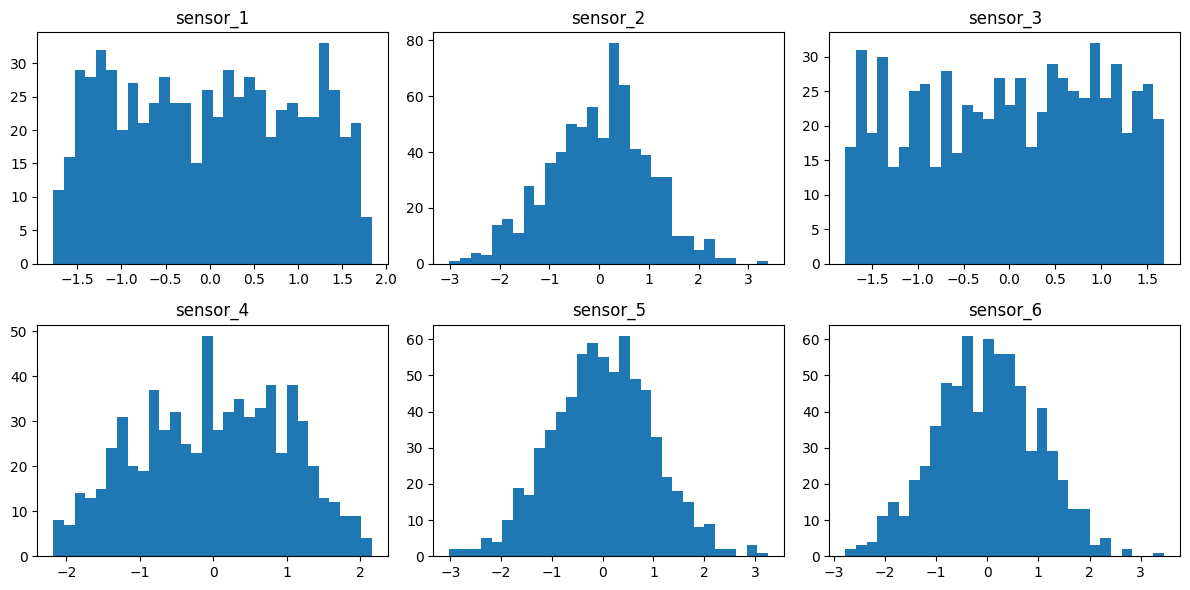

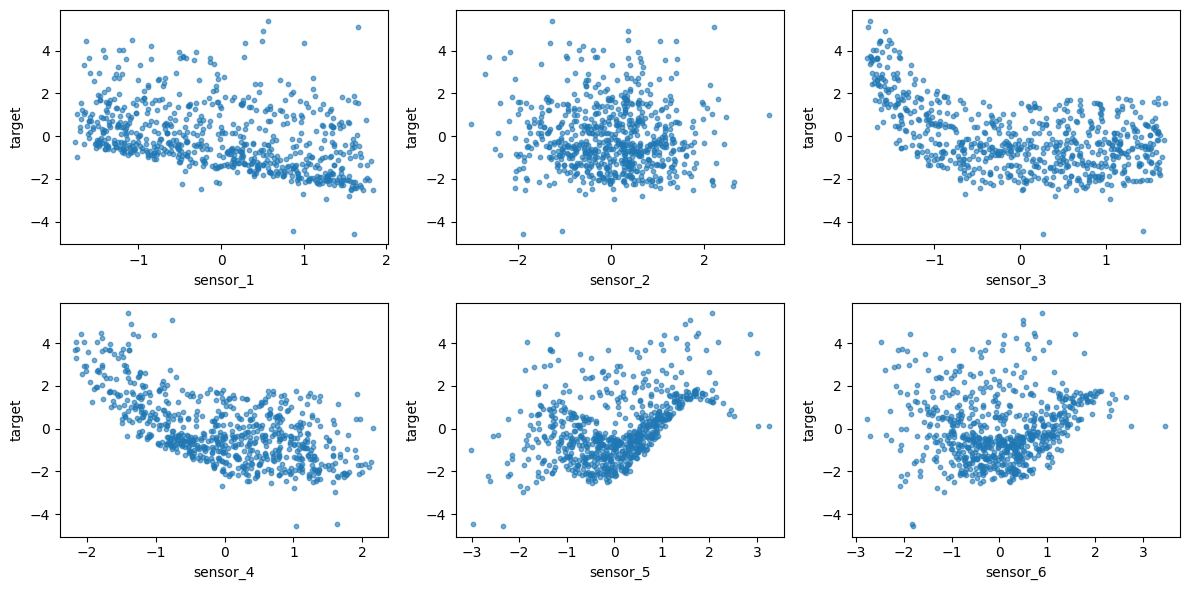

In [34]:
# Histograms of training features
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Loop through the first 6 features and plot their distributions
for i, ax in enumerate(axes.ravel()):
    ax.hist(X_scaled[:, i], bins=30)
    ax.set_title(f"sensor_{i+1}")

plt.tight_layout()
plt.show()

# Scatter plots: each feature vs. target
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Loop through the first 6 features and plot their relationship with the target
for i, ax in enumerate(axes.ravel()):
    ax.scatter(X_scaled[:, i], Y_train_input, s=10, alpha=0.6)
    ax.set_xlabel(f"sensor_{i+1}")
    ax.set_ylabel("target")

plt.tight_layout()
plt.show()
